<a href="https://colab.research.google.com/github/eojo91/ds2_2023_summer_ml_project1/blob/Kyungheui.Cho/Project1_forward%20selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 1 : Human Activity Recognition

### 프로젝트 제출 가이드
- 제출 기한: 2023년 8월 4일 (금) 자정
- 제출 내용: `4. 구현` 셀에 `LRClassifier` 변수를 구현하고, `Project1.ipynb`를 제출
- 제출 방법: `ta_ml@hcs.snu.ac.kr`로 이메일 제출 (여러 번 제출시 마지막 버전을 사용)
- 메일 제목: `X조 ML Project 1`
- 점수 비중: 10%


### 채점 기준 [총 100점]
1. `5. 테스트` 셀이 잘 실행되어야 합니다. [+100점]
2. `LRClassifier`는 Logistic Regression을 이용해서 분류를 수행해야 합니다. [-100점]
3. 띄어쓰기, 주석, Data Plotting 등 실행과 상관없는 부분은 수정이 가능하고, 실행과 관련된 부분은 `4. 구현` 셀만 수정하여야 합니다. [-50점]


### 참고 사항
1. Project 1에서 성능은 채점 기준에 들어가지 않습니다.
2. `sklearn` 외의 다른 라이브러리를 사용해도 됩니다.

---
## 목차
1. 프로젝트 개요
2. 데이터<br/>
  2.1. 데이터 로드 방법<br/>
  2.2. 데이터 개요<br/>
  2.3. 데이터 샘플 예제<br/>
3. `KNNClassifier` 예제
4. 구현
5. 테스트

### 1. 프로젝트 개요
- 5초간 손목의 가속도계 센서 데이터를 이용해서 그 사람의 행동을 예측하는 분류기를 만듭니다.

<img src="https://gitlab.com/machine-learning-course1/ml-project-samsung-2023-summer/-/raw/master/images/simple_pipeline.png" style='width:70%; margin-bottom:10px'>
<div style='text-align:center; font-weight:bold;'>그림 1. Walking, Running 예제 데이터</div>

### Import libraries

In [1]:
import pickle
from urllib.request import urlopen

import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import cross_val_score, LeaveOneGroupOut
%matplotlib inline

### 2. 데이터
#### 2.1. 데이터 로드

In [2]:
def load_data(local=False):
    """
    For colab, use local = False.
    It takes a few minutes to download.
    """
    if local:
        DATA_PATH = 'data/train.pkl'
        with open(DATA_PATH, 'rb') as f:
            df = pickle.load(f)
    else:
        DATA_URL = 'https://gitlab.com/machine-learning-course1/ml-project-samsung-2023-summer/-/raw/master/data/train.pkl?inline=false'
        df = pickle.load(urlopen(DATA_URL))

    X, Y = np.stack(df['Data']), np.stack(df['Motion'])  # np.stack : pandas.Series => np.ndarray
    groups = np.stack(df['Subject'])  # For LeaveOneGroupOut

    return X, Y, groups

In [ ]:
X, Y, groups = load_data(local=False)

print(X.shape, Y.shape, groups.shape)

(13940, 500, 3) (13940,) (13940,)


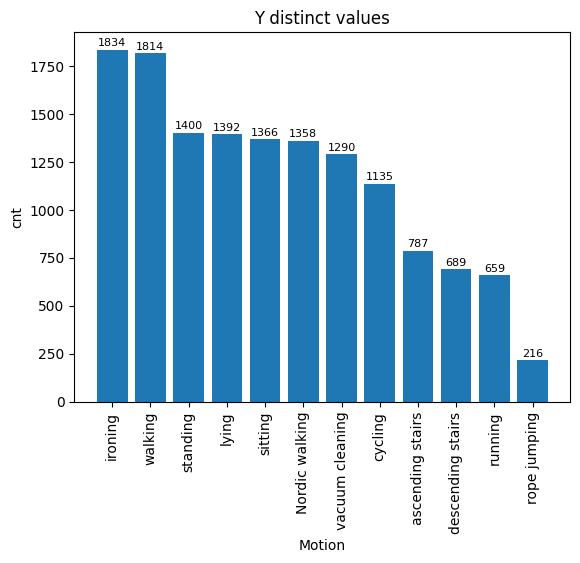

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt

# Y 배열에서 고유한 값들과 각 값들의 개수를 구하기
unique_values, value_counts = np.unique(Y, return_counts=True)

# 고유한 값들과 개수를 내림 차순으로 정렬하기
sorted_indices = np.argsort(value_counts)[::-1]
unique_values = unique_values[sorted_indices]
value_counts = value_counts[sorted_indices]

# 막대 그래프 그리기
plt.bar(unique_values, value_counts)

# 각 막대 위에 해당하는 y 값 표시
# plt.text 함수는 각 막대 위에 y 값을 표시합니다.
# unique_values[i]는 x 위치, v + 20는 y 위치(막대의 끝 위에 위치시키기 위해 20를 더했습니다),
# str(v)는 표시할 텍스트입니다. ha='center'는 텍스트를 가로 중앙에 맞춥니다.
for i, v in enumerate(value_counts):
    plt.text(unique_values[i], v + 20, str(v), ha='center', fontsize=8)

# 그래프에 제목과 축 레이블 추가
plt.title("Y distinct values")
plt.xlabel("Motion")
plt.ylabel("cnt")

# x축 레이블 세로로 표시하기
plt.xticks(rotation=90)

# 그래프 표시
plt.show()


#### 2.2. 데이터 개요
- 각 샘플은 `Subject`, `Data`, `Motion` 값으로 이루어져 있습니다.
  - `Subject`: 실험자 ID (`int` 타입)
  - `Data`: (500, 3) 형태의 `numpy array` (`numpy array` 타입)
    - 5초 동안 100Hz로 3축 데이터를 모으면 (500, 3) 형태의 데이터가 됩니다.
  - `Motion`: 실험자의 실제 행동 ( `str` 타입)
    - ex. `walking`, `running`, ...

- `Data` 정보를 가지고 `Motion` 값을 유추해야합니다.
- `Subject`는 Cross Validation에 활용하기 위해 제공됩니다. Cross Validation의 경우 `CrossValidation.ipynb`를 참고해주세요.

#### 2.3. 데이터 샘플 예제

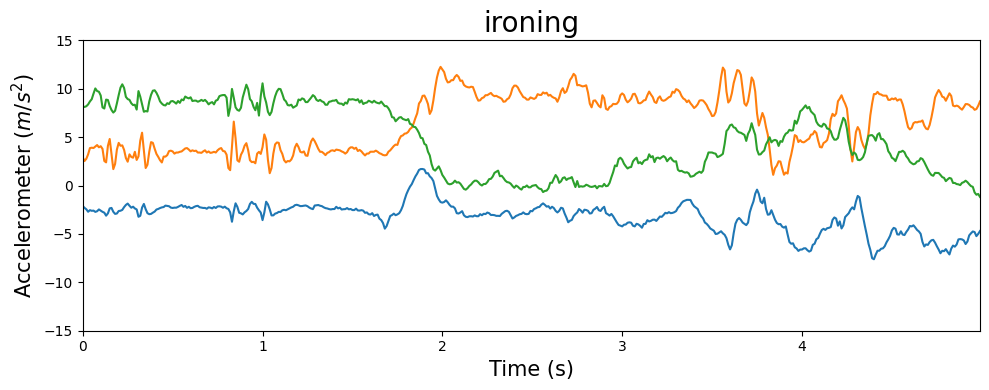

In [ ]:
FPS = 100

X_sample, Y_sample = X[0], Y[0]
time_stamps = np.arange(0, len(X_sample)) / FPS


fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(time_stamps, X_sample)

ax.set_title(Y_sample, fontsize=20)
ax.set_xlabel('Time (s)', fontsize=15)
ax.set_ylabel('Accelerometer ($m/s^2$)', fontsize=15)
ax.set_xlim(min(time_stamps), max(time_stamps))
ax.set_ylim(-15, 15)

fig.tight_layout()
fig.show()

### 3. `KNNClassifier` 예제
- 이 예제는 예시일 뿐이고, 다른 방식으로 구현하셔도 됩니다. 채점기준을 참고해주세요.

```python
import numpy as np
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer


def extract_features_from_a_single_sample(X_sample: np.ndarray) -> np.ndarray:
    """
    Extract features from a single sample

    Parameters
    ----------
    X_sample : array of shape (500, 3)
        100Hz * 5 seconds => 500
        3 axis (x, y, z)  => 3

    Returns
    -------
    features : array with (p,) shape
        Extracted features from X_sample
    """
    X_fft = np.abs(np.fft.fft(X_sample, axis=0))[1:]
    
    mean = np.mean(X_sample, axis=0)
    std = np.std(X_sample, axis=0)
    
    features = np.hstack([mean, std])
    return features


def extract_features_from_multiple_samples(X_samples: np.ndarray) -> np.ndarray:
    """
    Extract features from multiple samples

    Parameters
    ----------
    X_samples : array of shape (n, 500, 3)
        List of data samples

    Returns
    -------
    array of shape (n, p)
        Extracted features from X_samples
    """
    return np.asarray([extract_features_from_a_single_sample(X_sample) for X_sample in X_samples])


# Example Classifier
# You can use python class instance instead of the Pipeline.
KNNClassifier = Pipeline([
    ('feature_extractor', FunctionTransformer(extract_features_from_multiple_samples)),
    ('preprocessor', PCA()),
    ('classifier', KNeighborsClassifier()),
])
```

#### `KNNClassifier` 구현 순서
##### a. `extract_features_from_a_single_sample`
- (500, 3) 크기의 데이터 샘플 하나를 입력받아 특성들을 1D numpy array로 반환합니다.
- 주어진 예제에서는 `mean`, `std` 특성들을 뽑아내고 있습니다.
- 추가적인 특성들을 구현할 때 아래 목록을 참고하실 수 있습니다.
  - Time Domain 특성
    - min, max, amplitude, sum, absolute sum, euclidean norm, mean, absolute mean, mean absolute deviation, variance, standard deviation, zero crossings, auto-correlations, skewness, kurtosis, percentiles, power, root mean square, cross-correlation of axes, ...
  - Frequency Domain 특성
    - energy, entropy, power, spectral centroid, mean, median, standard deviation, dominant frequency, ...

##### b. 전처리기 (Preprocessor) 추가
- a.에서 뽑아낸 특성들을 전처리합니다.
- 주어진 예제에는 `PCA`가 포함되어 있습니다.
- 아래 링크에서 `sklearn`이 제공하는 전처리기 목록을 확인하실 수 있습니다.
  - [`sklearn.preprocessing` documentation](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing).
- `sklearn` 외의 라이브러리를 이용하셔도 됩니다.


##### c. 분류기 튜닝
- a.에서 어떤 특성을 사용할지, b.에서 어떤 전처리기를 사용할지, 전처리기/분류기의 하이퍼파라미터를 어떻게 정할지 등을 바꾸어가며 성능을 높입니다.
- Cross Validation을 이용해서 테스트 결과를 예측하며 하이퍼파라미터를 설정할 수 있습니다.
- 자세한 튜닝 방법은 `CrossValidation.ipynb`를 참고해주세요.

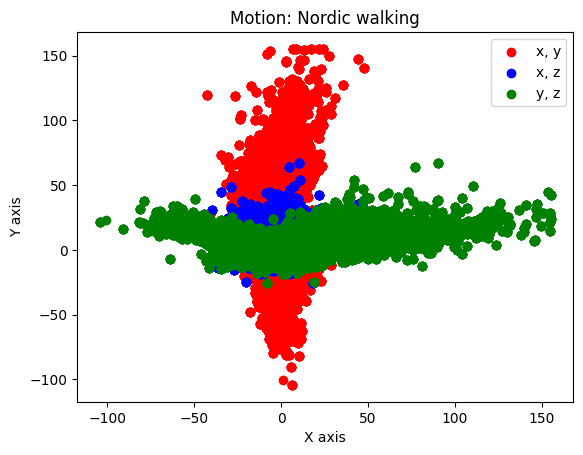

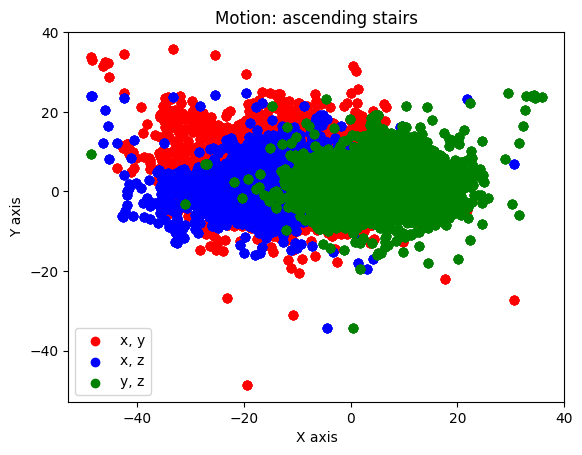

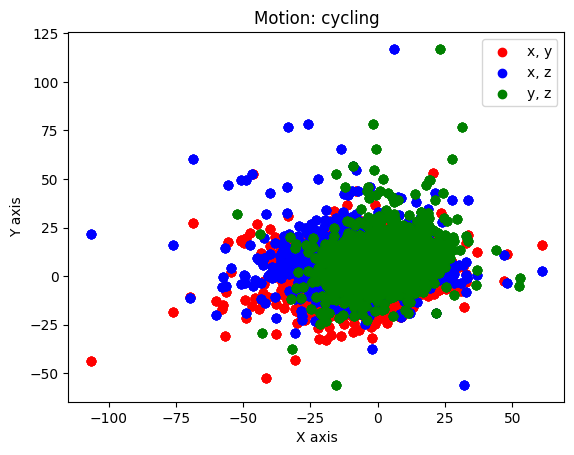

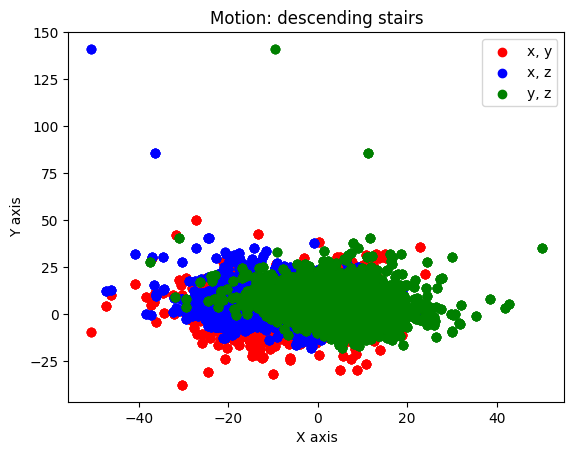

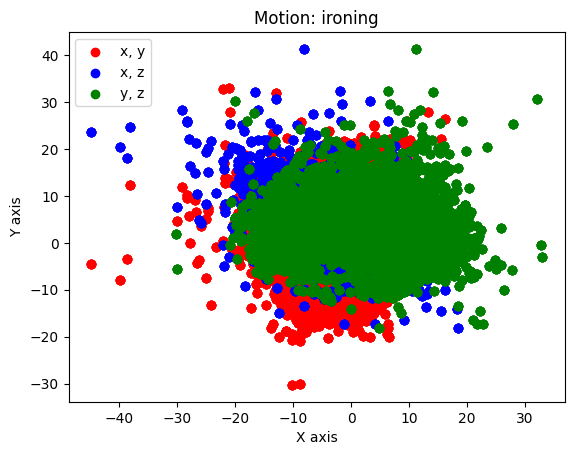

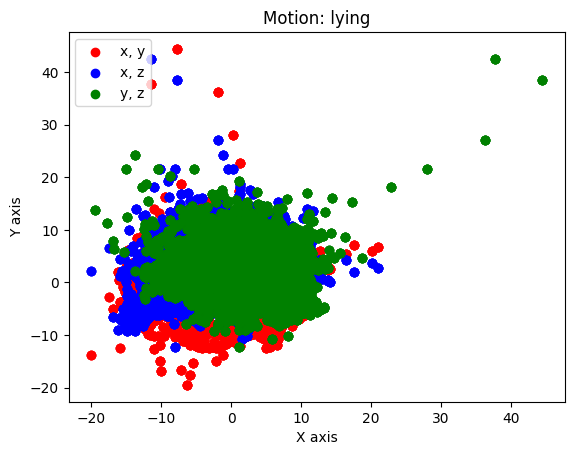

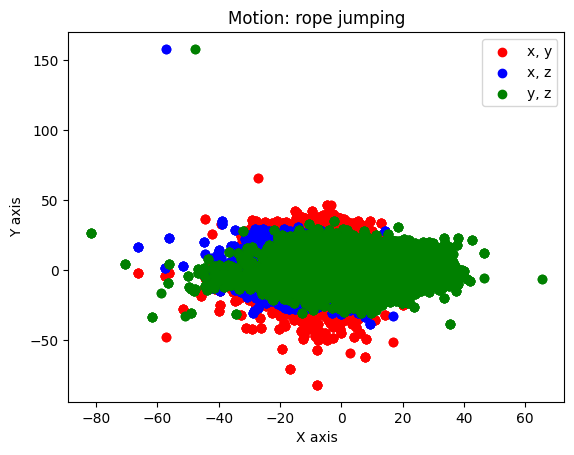

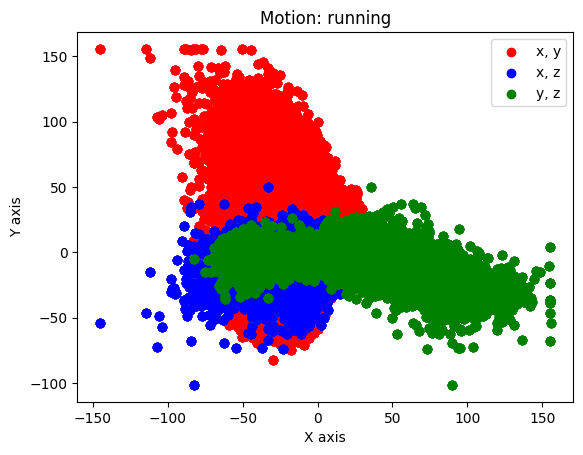

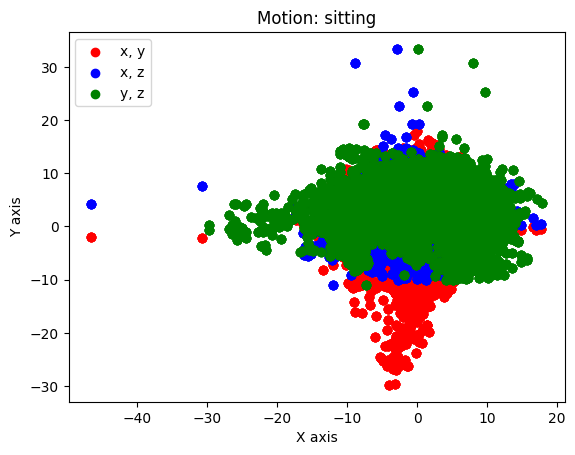

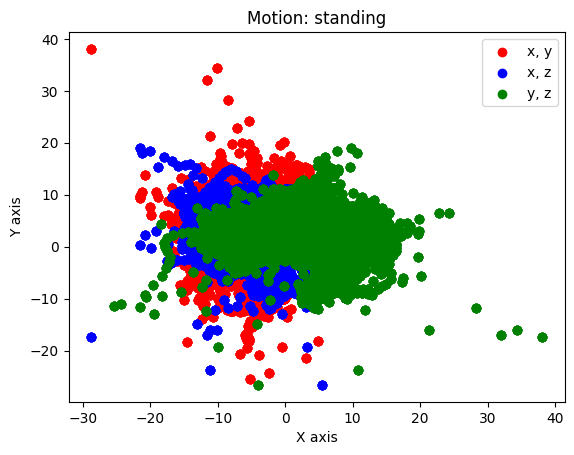

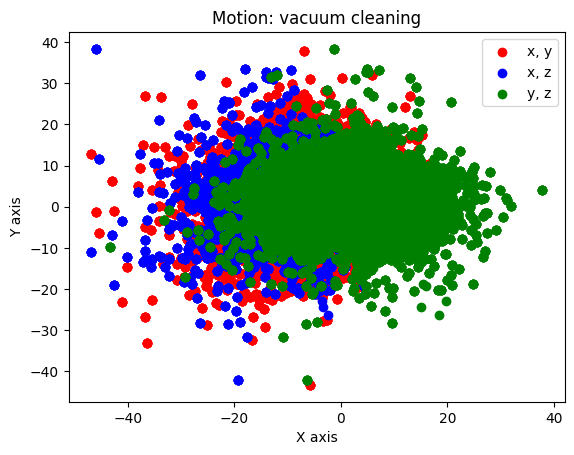

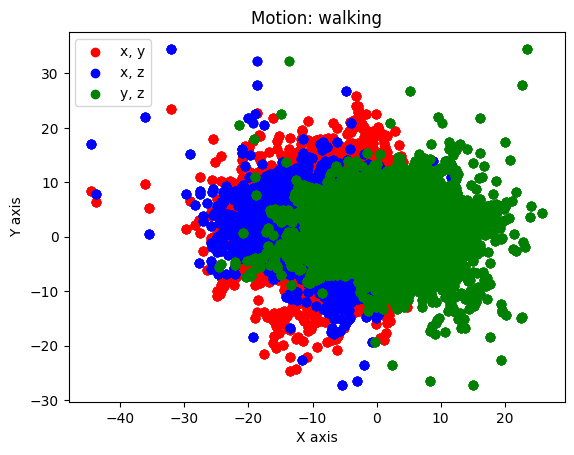

In [ ]:
# y 값의 종류를 확인합니다.
unique_y = np.unique(Y)

# 각 y 값의 종류별로 그래프를 그리고, 각 그래프에는 x 값의 x, y, z별 산포를 표현합니다.
for y_val in unique_y:
    # y 값이 해당 y_val인 데이터를 선택합니다.
    y_mask = (Y == y_val)
    x_data = X[y_mask]

    # 각 축의 데이터를 가져옵니다.
    x_axis = x_data[:, :, 0]  # x 축 데이터
    y_axis = x_data[:, :, 1]  # y 축 데이터
    z_axis = x_data[:, :, 2]  # z 축 데이터

    # 그래프를 그립니다.
    plt.figure()
    plt.scatter(x_axis, y_axis, c='r', label='x, y')  # x, y 축 데이터를 빨간색으로 표시
    plt.scatter(x_axis, z_axis, c='b', label='x, z')  # x, z 축 데이터를 파란색으로 표시
    plt.scatter(y_axis, z_axis, c='g', label='y, z')  # y, z 축 데이터를 초록색으로 표시
    plt.xlabel('X axis')
    plt.ylabel('Y axis')
    plt.title(f"Motion: {y_val}")
    plt.legend()
    plt.show()

['Nordic walking' 'ascending stairs' 'cycling' 'descending stairs'
 'ironing' 'lying' 'rope jumping' 'running' 'sitting' 'standing'
 'vacuum cleaning' 'walking']
[1358  787 1135  689 1834 1392  216  659 1366 1400 1290 1814]


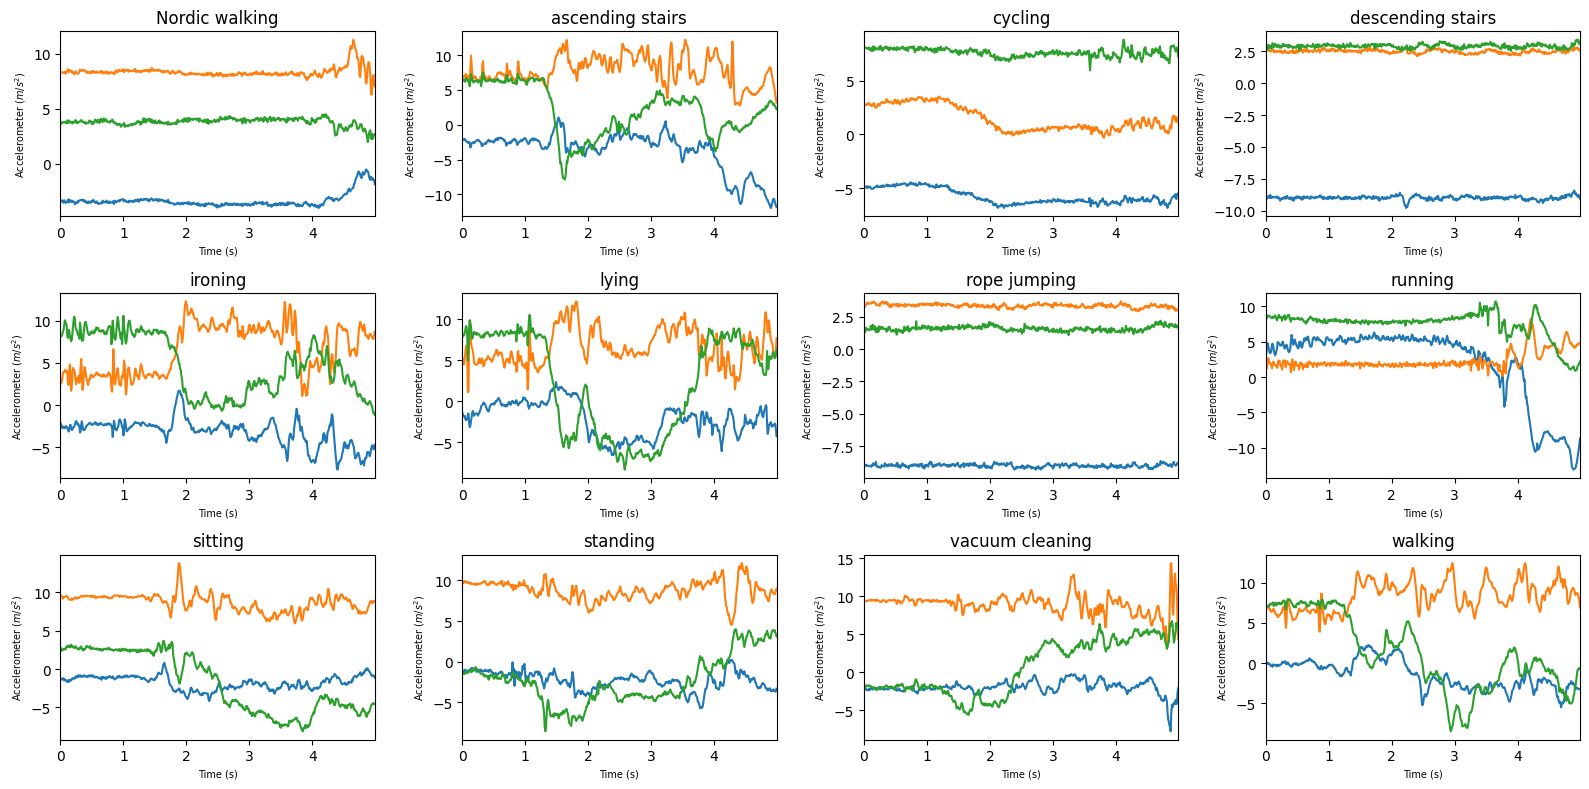

In [ ]:
y_name, y_first_index, y_counts = np.unique(Y, return_index=True, return_counts=True)
print(y_name)
print(y_counts)

fig, axes = plt.subplots(3, 4, figsize=(16, 8))

for i in range(len(y_first_index)):
  idx = y_first_index[i]
  X_sample, Y_sample = X[idx], Y[idx]
  time_stamps = np.arange(0, len(X_sample)) / 100

  ax = axes[i // 4, i % 4]

  ax.plot(time_stamps, X_sample)

  ax.set_title(Y_sample, fontsize=12)
  ax.set_xlabel('Time (s)', fontsize=7)
  ax.set_ylabel('Accelerometer ($m/s^2$)', fontsize=7)
  ax.set_xlim(min(time_stamps), max(time_stamps))

  fig.tight_layout()
  fig.show()

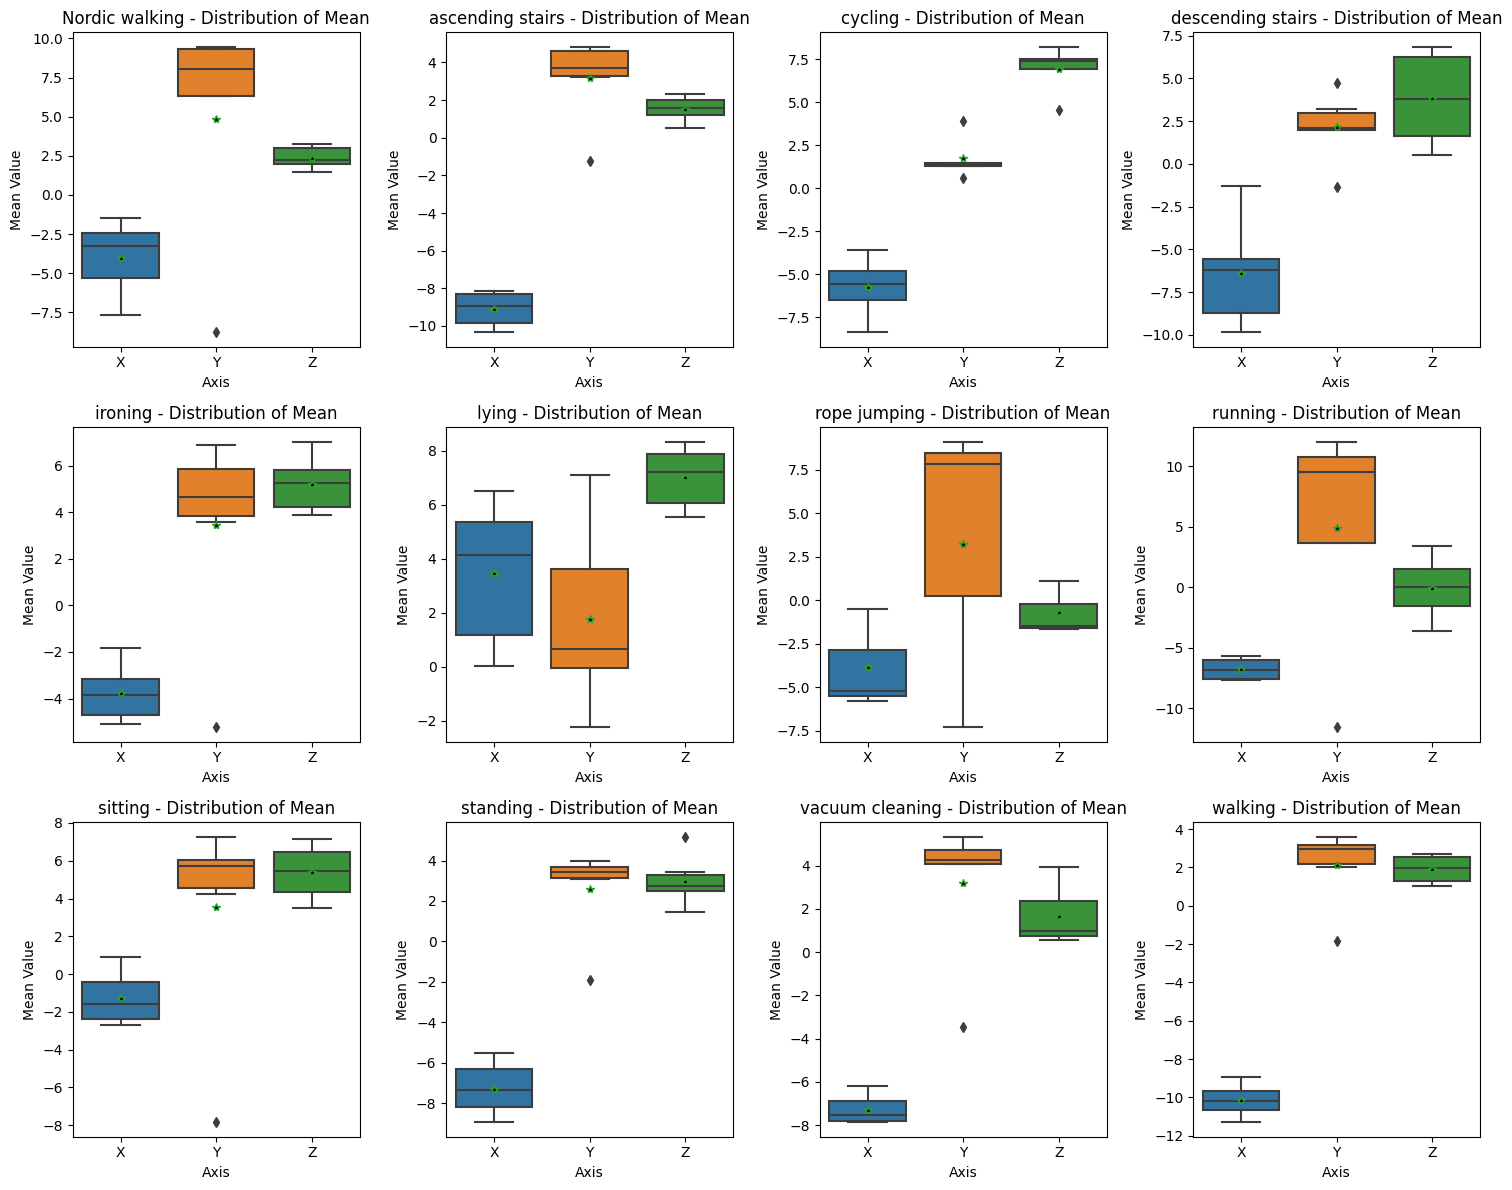

<Figure size 640x480 with 0 Axes>

In [ ]:
# 왠지 사용자별 모션에 따라 x, y, z 값의 range가 다를것 같아서.. 누군가는 빨리 달리고, 누군가는 줄넘기 할대 높게 뛰고 해서.. normalize가 필요하지 않을가 싶어서..
# 모션별로 사용자별 x, y, z 값의 평균을 저장할 리스트
motion_data_list = []

# 모션별로 사용자별 x, y, z 값의 평균 계산
for motion in unique_motions:
    motion_indices = np.where(Y == motion)[0]
    motion_subjects = groups[motion_indices]
    unique_subjects_in_motion = np.unique(motion_subjects)

    for subject in unique_subjects_in_motion:
        subject_indices = np.where(motion_subjects == subject)[0]
        x_mean = X[motion_indices[subject_indices], :, 0].mean()
        y_mean = X[motion_indices[subject_indices], :, 1].mean()
        z_mean = X[motion_indices[subject_indices], :, 2].mean()

        motion_data_list.append((motion, subject, 'X', x_mean))
        motion_data_list.append((motion, subject, 'Y', y_mean))
        motion_data_list.append((motion, subject, 'Z', z_mean))

# DataFrame으로 변환
motion_df = pd.DataFrame(motion_data_list, columns=['Motion', 'Subject', 'Axis', 'MeanValue'])

# 모션별로 그래프 그리기
plt.figure(figsize=(15, len(unique_motions))) # 세로 길이를 모션의 개수만큼 설정
for idx, motion in enumerate(unique_motions):
    plt.subplot(len(unique_motions) // 4, 4, idx + 1)
    sns.boxplot(x='Axis', y='MeanValue', data=motion_df[motion_df['Motion'] == motion],
                meanprops={"marker":"*", "markerfacecolor":"black"}, showmeans=True) # 평균값을 *로 표기
    plt.title(f'{motion} - Distribution of Mean')
    plt.xlabel('Axis')
    plt.ylabel('Mean Value')

plt.tight_layout()
plt.show()

plt.tight_layout()
plt.show()


### 4. 구현

In [3]:
# @title 사용 가능한 모든 Feature 추출
import numpy as np
from numpy.fft import fft

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import cross_val_score, LeaveOneGroupOut

from scipy.fft import fft
from scipy.stats import skew
from scipy.stats import kurtosis
from scipy.signal import correlate
from scipy.spatial.distance import euclidean


from tqdm import tnrange, tqdm_notebook  #이터레이션 돌면서 얼마나 걸리는지를 보여줌.

import time



def single_sample_extractor(X_sample: np.ndarray) -> np.ndarray:

    X_fft = np.abs(np.fft.fft(X_sample, axis=0))[1:]
    mean_val = np.mean(X_sample, axis=0)
    std_dev = np.std(X_sample, axis=0)
    auto_correlations = np.real(fft(X_fft * np.conj(X_fft), axis=0))
    first_derivative = np.gradient(X_sample, axis=0)

    min_val = np.min(X_sample, axis=0)
    max_val = np.max(X_sample, axis=0)
    amplitude = max_val - min_val
    sum_val = np.sum(X_sample, axis=0)
    abs_sum = np.sum(np.abs(X_sample), axis=0)
    euclidean_norm = np.linalg.norm(X_sample, axis=0)
    mean_val = np.mean(X_sample, axis=0)
    abs_mean = np.mean(np.abs(X_sample), axis=0)
    mean_abs_dev = np.mean(np.abs(X_sample - mean_val), axis=0)
    variance_val = np.var(X_sample, axis=0)
    zero_crossings = ((X_sample[:-1] * X_sample[1:]) < 0).sum(axis=0)
    skewness_val = skew(X_sample, axis=0)
    kurtosis_val = kurtosis(X_sample, axis=0)
    percentiles_val = np.percentile(X_sample, [25, 50, 75], axis=0)
    power_val = np.sum(X_sample**2, axis=0) / len(X_sample)
    rms = np.sqrt(np.mean(X_sample**2, axis=0))
    cross_correlation = [np.correlate(X_sample[:, i], X_sample[:, i], mode='full') for i in range(X_sample.shape[1])]
    cross_correlation = np.array(cross_correlation)
    energy_val = np.sum(X_sample**2, axis=0)

    # 엔트로피 계산
    prob_data = X_sample - np.min(X_sample, axis=0)  # 음수 값 제거
    prob_data = prob_data / np.sum(prob_data, axis=0)  # 정규화
    entropy_val = -np.sum(prob_data * np.log2(prob_data + np.finfo(float).eps), axis=0)  # 0 로그 0 문제 방지

    spectral_centroid = np.sum(np.fft.fftfreq(X_sample.shape[0])[:, None] * np.abs(fft(X_sample, axis=0)), axis=0) / np.sum(np.abs(fft(X_sample, axis=0)), axis=0)
    median_val = np.median(X_sample, axis=0)
    dominant_frequency = np.argmax(np.abs(fft(X_sample, axis=0)), axis=0)

    # 자기 상관 특성
    auto_corr_mean = np.mean(auto_correlations, axis=0)
    auto_corr_max = np.max(auto_correlations, axis=0)
    auto_corr_median = np.median(auto_correlations, axis=0)

    # 교차 상관 특성
    cross_corr_mean = np.mean(cross_correlation, axis=0)
    cross_corr_max = np.max(cross_correlation, axis=0)
    cross_corr_median = np.median(cross_correlation, axis=0)

    # 1. Signal Derivatives
    second_derivative = np.gradient(first_derivative, axis=0)

    # 6. Local Features
    local_fisrt_median = np.median(X_sample[:100], axis=0) # 예: 처음 100개 샘플의 최대값
    local_last_median = np.median(X_sample[:-100], axis=0) # 예: 처음 100개 샘플의 최소값

    fft_mean = np.mean(X_fft, axis=0)
    fft_std = np.std(X_fft, axis=0)

    # 추가 특성
    jerk = np.gradient(np.gradient(X_sample, axis=0), axis=0)
    waveform_length = np.sum(np.abs(np.diff(X_sample, axis=0)), axis=0)
    mean_crossing_rate = ((X_sample[:-1] - np.mean(X_sample, axis=0)) * (X_sample[1:] - np.mean(X_sample, axis=0)) < 0).sum(axis=0)
    peak_to_peak_distance = np.max(X_sample, axis=0) - np.min(X_sample, axis=0)
    magnitude = np.linalg.norm(X_sample, axis=1)
    orientation = np.arctan2(X_sample[:, 1], X_sample[:, 0])  # 2D orientation 예시
    dtw_distance = euclidean(X_sample[0], X_sample[-1])  # DTW 거리 예시

    features = np.hstack([
        X_fft.ravel(), mean_val, std_dev, auto_correlations.ravel(),
        first_derivative.ravel(), min_val, max_val, amplitude, sum_val,
        abs_sum, euclidean_norm, abs_mean, mean_abs_dev,
        variance_val, zero_crossings, skewness_val, kurtosis_val,
        percentiles_val.ravel(), power_val, rms, cross_correlation.ravel(),
        energy_val, entropy_val, spectral_centroid, median_val,
        dominant_frequency, auto_corr_mean, auto_corr_max, auto_corr_median,
        cross_corr_mean, cross_corr_max, cross_corr_median, second_derivative.ravel(),
        local_fisrt_median, local_last_median, fft_mean, fft_std,
        jerk.ravel(), waveform_length, mean_crossing_rate, peak_to_peak_distance,
        magnitude, orientation, dtw_distance
    ])
    return features


def extractor(X_samples: np.ndarray) -> np.ndarray:
  return np.asarray([single_sample_extractor(X_sample) for X_sample in X_samples])


In [5]:

# 사용 가능한 모든 특성
all_feature_names = [
    'X_fft_ravle', 'mean_val', 'std_dev', 'auto_correlations',
    'first_derivative','min_val', 'max_val', 'amplitude', 'sum_val',
    'abs_sum', 'euclidean_norm', 'abs_mean', 'mean_abs_dev',
    'variance_val', 'zero_crossings', 'skewness_val', 'kurtosis_val',
    'percentiles_val', 'power_val', 'rms', 'cross_correlation',
    'energy_val', 'entropy_val', 'spectral_centroid', 'median_val',
    'dominant_frequency', 'auto_corr_mean','auto_corr_max','auto_corr_median',
    'cross_corr_mean','cross_corr_max','cross_corr_median','second_derivative.ravel',
    'local_fisrt_median', 'local_last_median', 'fft_mean', 'fft_std',
    'jerk.ravel', 'waveform_length', 'mean_crossing_rate', 'peak_to_peak_distance',
    'magnitude', 'orientation', 'dtw_distance'
]

X, Y, groups = load_data(local=False)

# 특성 추출
features = extractor(X)  # X는 입력 데이터

# 초기 설정
selected_features = []
remaining_features = all_feature_names.copy()
best_score = 0
total_elapsed_time = 0


# Forward selection
while remaining_features:
    scores = []
    for feature in remaining_features:
        start_time = time.time()

        current_features = selected_features + [feature]
        feature_indices = [all_feature_names.index(name) for name in current_features]
        selected_features_data = np.hstack([features[:, i:i+1] for i in feature_indices])

        # Classifier Pipeline
        LRClassifier = Pipeline([
          ('normalizer', StandardScaler()),
          ('pca', PCA()),
          ('classifier', LogisticRegression(solver='saga', max_iter=1000, n_jobs=-1)),
        ])


        score = cross_val_score(
            LRClassifier,
            selected_features_data, Y, groups=groups,
            scoring='f1_macro',
            cv=LeaveOneGroupOut()
        ).mean()
        scores.append(score)
        end_time = time.time()

        elapsed_time = end_time - start_time
        total_elapsed_time += elapsed_time

        minutes, seconds = divmod(elapsed_time, 60)
        print(f"Score {score:.4f} with features {current_features}, Time elapsed: {int(minutes)}분 {int(seconds)}초")

    # 최고 점수를 가진 특성을 선택
    best_new_score = max(scores)
    best_new_feature = remaining_features[scores.index(best_new_score)]
    if best_new_score > best_score:
        best_score = best_new_score
        selected_features.append(best_new_feature)
        remaining_features.remove(best_new_feature)
        print(f"New best score {best_score:.4f} with features {selected_features}")

        total_minutes, total_seconds = divmod(total_elapsed_time, 60)
        total_hours, total_minutes = divmod(total_minutes, 60)
        print(f"Total elapsed time: {int(total_hours)}시간 {int(total_minutes)}분 {int(total_seconds)}초")

    else:
        print("No improvement. Stopping.")
        total_minutes, total_seconds = divmod(total_elapsed_time, 60)
        total_hours, total_minutes = divmod(total_minutes, 60)
        print(f"Total elapsed time: {int(total_hours)}시간 {int(total_minutes)}분 {int(total_seconds)}초")

        break

print(f"Final best score {best_score:.4f} with features {selected_features}")
print("Total features in the list:", len(all_feature_names))
print("Total features tried:", len(selected_features))


Score 0.0952 with features ['X_fft_ravle'], Time elapsed: 0분 1초
Score 0.1134 with features ['mean_val'], Time elapsed: 0분 1초
Score 0.0656 with features ['std_dev'], Time elapsed: 0분 0초
Score 0.0882 with features ['auto_correlations'], Time elapsed: 0분 0초
Score 0.1006 with features ['first_derivative'], Time elapsed: 0분 0초
Score 0.0987 with features ['min_val'], Time elapsed: 0분 0초
Score 0.1099 with features ['max_val'], Time elapsed: 0분 0초
Score 0.1066 with features ['amplitude'], Time elapsed: 0분 0초
Score 0.0999 with features ['sum_val'], Time elapsed: 0분 0초
Score 0.0865 with features ['abs_sum'], Time elapsed: 0분 0초
Score 0.1049 with features ['euclidean_norm'], Time elapsed: 0분 0초
Score 0.0868 with features ['abs_mean'], Time elapsed: 0분 0초
Score 0.0985 with features ['mean_abs_dev'], Time elapsed: 0분 0초
Score 0.1305 with features ['variance_val'], Time elapsed: 0분 0초
Score 0.0998 with features ['zero_crossings'], Time elapsed: 0분 0초
Score 0.1548 with features ['skewness_val'], Time

KeyboardInterrupt: ignored

### 5. Cross-validation with subjects

In [ ]:
X, Y, groups = load_data(local=False)

# Scoring
scores = cross_val_score(
    LRClassifier,
    X, Y, groups=groups,
    scoring='f1_macro',
    cv=LeaveOneGroupOut())
print(np.mean(scores))